In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [ ]:
base_df_resampled = pd.read_csv("filtered_df.csv")

In [ ]:
base_df_resampled['timestamp_device'] = pd.to_datetime(base_df_resampled['timestamp_device'])

#Stacked LSTM

In [ ]:
# ==== Set random seed for reproducibility ====
np.random.seed(42)
tf.random.set_seed(42)

# ==== Prepare dataset ====
base_df = base_df_resampled.sort_values('timestamp_device')

# ==== Define features and targets ====
features_to_exclude = ['moisture_20cm', 'moisture_30cm', 'moisture_40cm', 'moisture_60cm', 'timestamp_device']
X_raw = base_df.drop(columns=features_to_exclude).values
y_raw = base_df[['moisture_20cm', 'moisture_30cm', 'moisture_40cm', 'moisture_60cm']].values  # Multi-output

# ==== Scale input features ====
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_raw)

# ==== Create sequences ====
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 12
X_seq, y_seq = create_sequences(X_scaled, y_raw, sequence_length)

# ==== Train-test split ====
split_index = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]

# ==== Custom Callback for R² and RMSE per target ====
class MultiOutputR2RMSECallback(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0)
        for i, depth in enumerate(['20cm', '30cm', '40cm', '60cm']):
            r2 = r2_score(self.y_val[:, i], y_pred[:, i])
            rmse = np.sqrt(mean_squared_error(self.y_val[:, i], y_pred[:, i]))
            print(f"Epoch {epoch+1} - Depth {depth}: R² = {r2:.4f}, RMSE = {rmse:.4f}")
# ==== Build Deeper Stacked LSTM ====
lstm_model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(4)  # Multi-output: 20, 30, 40, 60 cm
])

# ==== Compile model ====
lstm_model.compile(optimizer=Adam(), loss='mean_squared_error')

# ==== Early Stopping Callback ====
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
# ==== Train model ====
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[MultiOutputR2RMSECallback(X_test_seq, y_test_seq), early_stopping])
# ==== Final Evaluation ====
y_pred_final = lstm_model.predict(X_test_seq)

depth_labels = ['20cm', '30cm', '40cm', '60cm']
print("\n=== Final Stacked LSTM Results (Multi-depth) ===")
for i, depth in enumerate(depth_labels):
    mae = mean_absolute_error(y_test_seq[:, i], y_pred_final[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_seq[:, i], y_pred_final[:, i]))
    r2 = r2_score(y_test_seq[:, i], y_pred_final[:, i])
    print(f"{depth} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")

In [ ]:
#Expanding sequence length to 144

# ==== Set random seed for reproducibility ====
np.random.seed(42)
tf.random.set_seed(42)

# ==== Prepare dataset ====
base_df = base_df_resampled.sort_values('timestamp_device')

# ==== Define features and targets ====
features_to_exclude = ['moisture_20cm', 'moisture_30cm', 'moisture_40cm', 'moisture_60cm', 'timestamp_device']
X_raw = base_df.drop(columns=features_to_exclude).values
y_raw = base_df[['moisture_20cm', 'moisture_30cm', 'moisture_40cm', 'moisture_60cm']].values  # Multi-output

# ==== Scale input features ====
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_raw)

# ==== Create sequences ====
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 144
X_seq, y_seq = create_sequences(X_scaled, y_raw, sequence_length)

# ==== Train-test split ====
split_index = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]

# ==== Custom Callback for R² and RMSE per target ====
class MultiOutputR2RMSECallback(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0)
        for i, depth in enumerate(['20cm', '30cm', '40cm', '60cm']):
            r2 = r2_score(self.y_val[:, i], y_pred[:, i])
            rmse = np.sqrt(mean_squared_error(self.y_val[:, i], y_pred[:, i]))
            print(f"Epoch {epoch+1} - Depth {depth}: R² = {r2:.4f}, RMSE = {rmse:.4f}")
# ==== Build Deeper Stacked LSTM ====
lstm_model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(4)  # Multi-output: 20, 30, 40, 60 cm
])

# ==== Compile model ====
lstm_model.compile(optimizer=Adam(), loss='mean_squared_error')

# ==== Early Stopping Callback ====
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
# ==== Train model ====
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[MultiOutputR2RMSECallback(X_test_seq, y_test_seq), early_stopping])
# ==== Final Evaluation ====
y_pred_final = lstm_model.predict(X_test_seq)

depth_labels = ['20cm', '30cm', '40cm', '60cm']
print("\n=== Final Stacked LSTM Results (Multi-depth) ===")
for i, depth in enumerate(depth_labels):
    mae = mean_absolute_error(y_test_seq[:, i], y_pred_final[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_seq[:, i], y_pred_final[:, i]))
    r2 = r2_score(y_test_seq[:, i], y_pred_final[:, i])
    print(f"{depth} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")

In [ ]:
depth_labels = ['20cm', '30cm', '40cm', '60cm']

# === Visualization: Actual vs Predicted ===
def plot_actual_vs_predicted(y_true, y_pred, depth_labels):
    plt.figure(figsize=(16, 10))
    for i, depth in enumerate(depth_labels):
        plt.subplot(2, 2, i+1)
        plt.plot(y_true[:, i], label='Actual', alpha=0.7)
        plt.plot(y_pred[:, i], label='Predicted', alpha=0.7)
        plt.title(f'Actual vs Predicted at {depth}')
        plt.xlabel('Time Step')
        plt.ylabel('Soil Moisture')
        plt.legend()
    plt.tight_layout()
    plt.show()

# === Visualization: Error Distributions ===
def plot_error_distributions(y_true, y_pred, depth_labels):
    plt.figure(figsize=(16, 10))
    for i, depth in enumerate(depth_labels):
        errors = y_pred[:, i] - y_true[:, i]
        plt.subplot(2, 2, i+1)
        sns.histplot(errors, kde=True, bins=30, color='skyblue', edgecolor='black')
        plt.title(f'Error Distribution at {depth}')
        plt.xlabel('Prediction Error')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

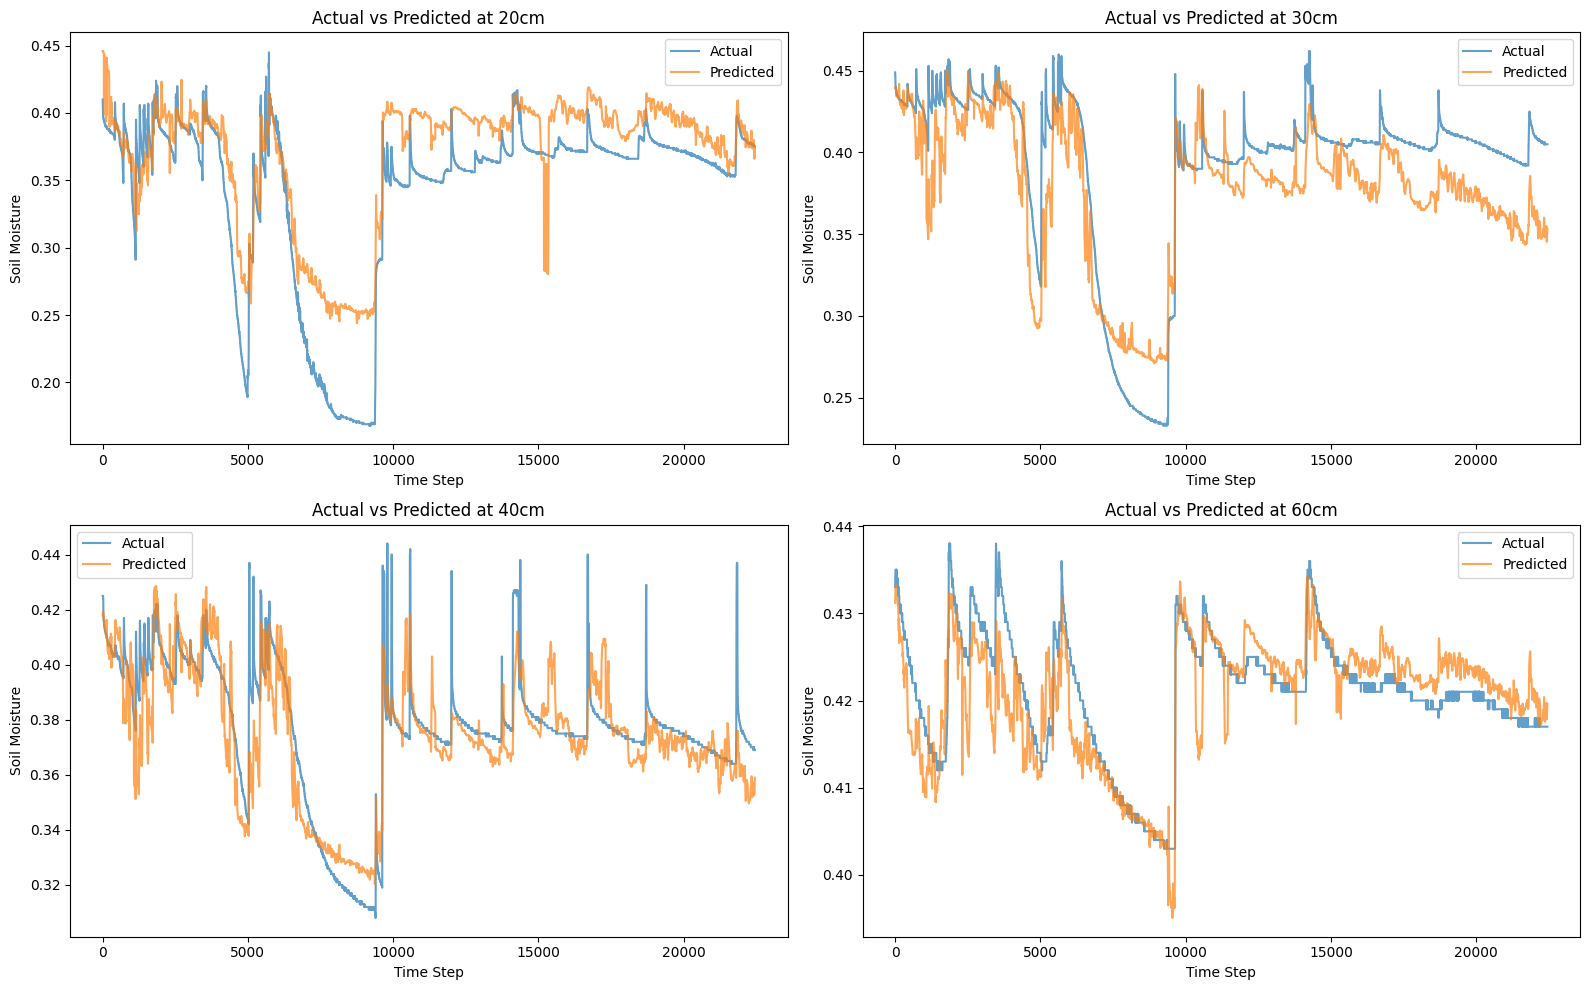

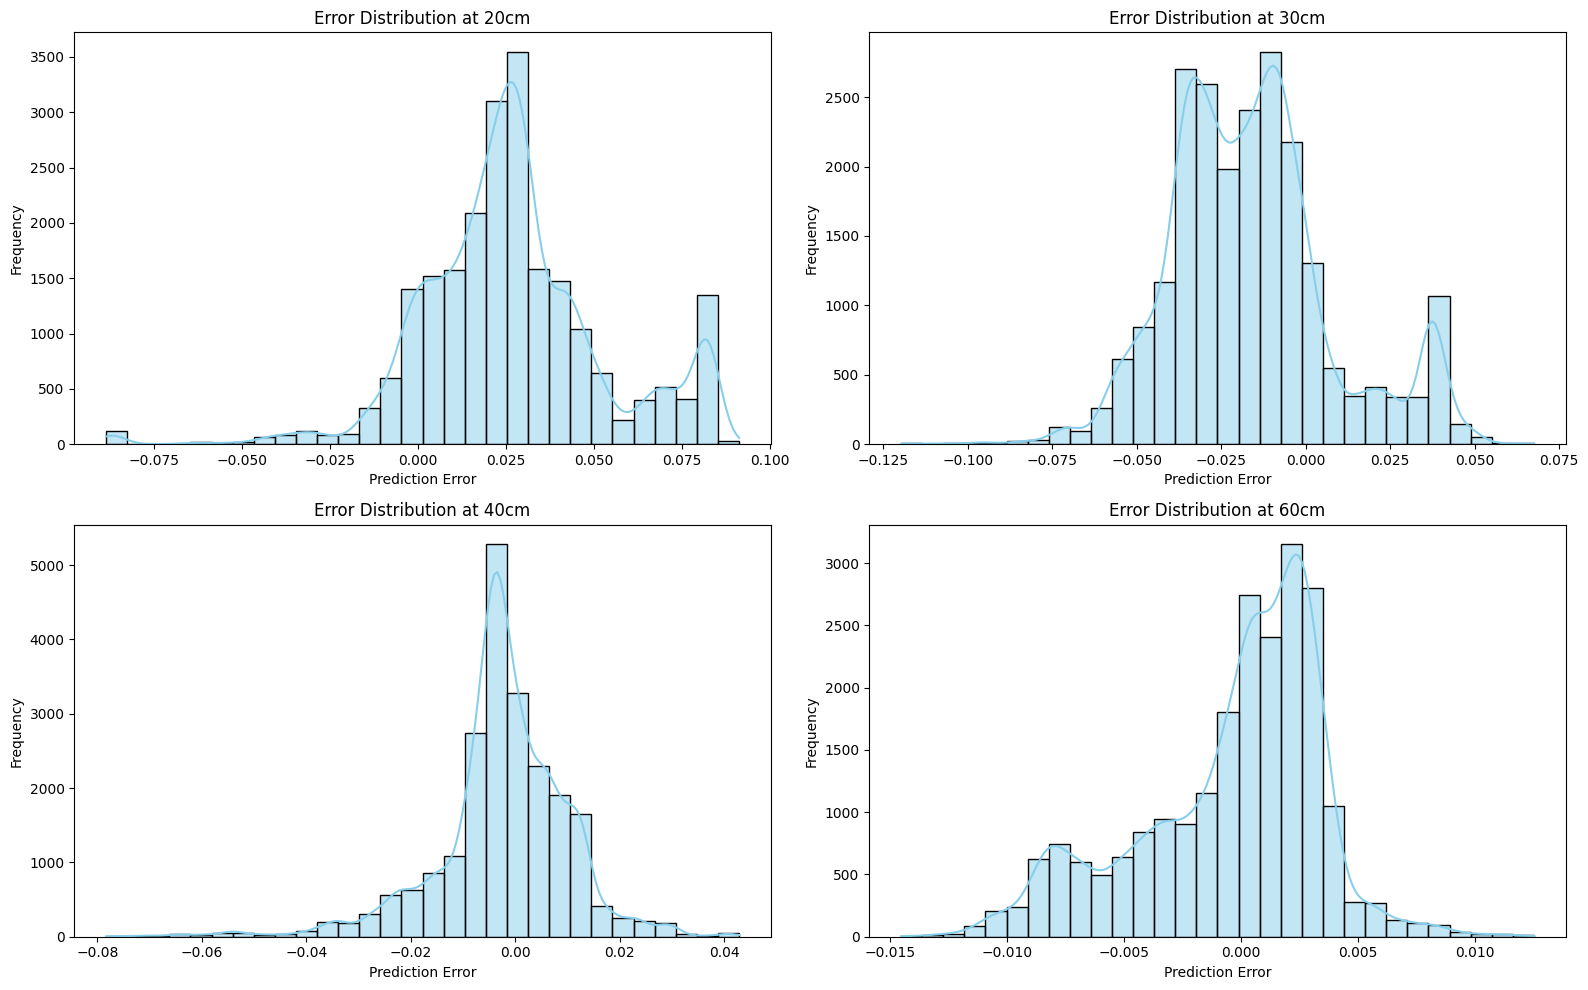

In [ ]:
# === Call Visualization Functions (Updated for Stacked LSTM Results) ===
plot_actual_vs_predicted(y_test_seq, y_pred_final, depth_labels)
plot_error_distributions(y_test_seq, y_pred_final, depth_labels)

#Predicitng moisture at 60cm depth from moisture 10 + 50 + meterological variables

In [ ]:
#base_df = df_wide.sort_values('timestamp_device')  # Ensure chronological order
base_df = base_df_resampled.sort_values('timestamp_device')  # Ensure chronological order


# ==== Define features to exclude ====
features_to_exclude = ['moisture_20cm', 'moisture_60cm', 'moisture_40cm', 'moisture_30cm', 'timestamp_device']

# ==== Create input and target arrays ====
X_raw = base_df.drop(columns=features_to_exclude).values
y_raw = base_df['moisture_60cm'].values

# ==== Scale features ====
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_raw)

# ==== Create sequences ====
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 12
X_seq, y_seq = create_sequences(X_scaled, y_raw, sequence_length)

# ==== Train-test split ====
split_index = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]
# ==== Custom Callback ====
class R2RMSECallback(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0).flatten()
        r2 = r2_score(self.y_val, y_pred)
        rmse = mean_squared_error(self.y_val, y_pred, squared=False)
        print(f"Epoch {epoch+1}: R² = {r2:.4f}, RMSE = {rmse:.4f}")

# ==== Build LSTM model ====
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
lstm_model.add(Dense(1))

# ==== Compile model ====
lstm_model.compile(optimizer=Adam(), loss='mean_squared_error')

from tensorflow.keras.callbacks import EarlyStopping

# ==== Early Stopping Callback ====
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ==== Train model ====
lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[R2RMSECallback(X_test_seq, y_test_seq), early_stopping]
)

# ==== Final Evaluation ====
y_pred_final = lstm_model.predict(X_test_seq).flatten()
final_mae = mean_absolute_error(y_test_seq, y_pred_final)
final_rmse = mean_squared_error(y_test_seq, y_pred_final, squared=False)
final_r2 = r2_score(y_test_seq, y_pred_final)

# ==== Print final results ====
print("\n=== Final LSTM Results (Time Sequences) ===")
print(f"MAE: {final_mae:.4f}, RMSE: {final_rmse:.4f}, R²: {final_r2:.4f}")

In [ ]:
sequence_length = 144
X_seq, y_seq = create_sequences(X_scaled, y_raw, sequence_length)

# ==== Train-test split ====
split_index = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]
# ==== Custom Callback ====
class R2RMSECallback(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0).flatten()
        r2 = r2_score(self.y_val, y_pred)
        rmse = mean_squared_error(self.y_val, y_pred, squared=False)
        print(f"Epoch {epoch+1}: R² = {r2:.4f}, RMSE = {rmse:.4f}")

# ==== Build LSTM model ====
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
lstm_model.add(Dense(1))

# ==== Compile model ====
lstm_model.compile(optimizer=Adam(), loss='mean_squared_error')

from tensorflow.keras.callbacks import EarlyStopping

# ==== Early Stopping Callback ====
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ==== Train model ====
lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[R2RMSECallback(X_test_seq, y_test_seq), early_stopping]
)

# ==== Final Evaluation ====
y_pred_final = lstm_model.predict(X_test_seq).flatten()
final_mae = mean_absolute_error(y_test_seq, y_pred_final)
final_rmse = mean_squared_error(y_test_seq, y_pred_final, squared=False)
final_r2 = r2_score(y_test_seq, y_pred_final)

# ==== Print final results ====
print("\n=== Final LSTM Results (Time Sequences) ===")
print(f"MAE: {final_mae:.4f}, RMSE: {final_rmse:.4f}, R²: {final_r2:.4f}")

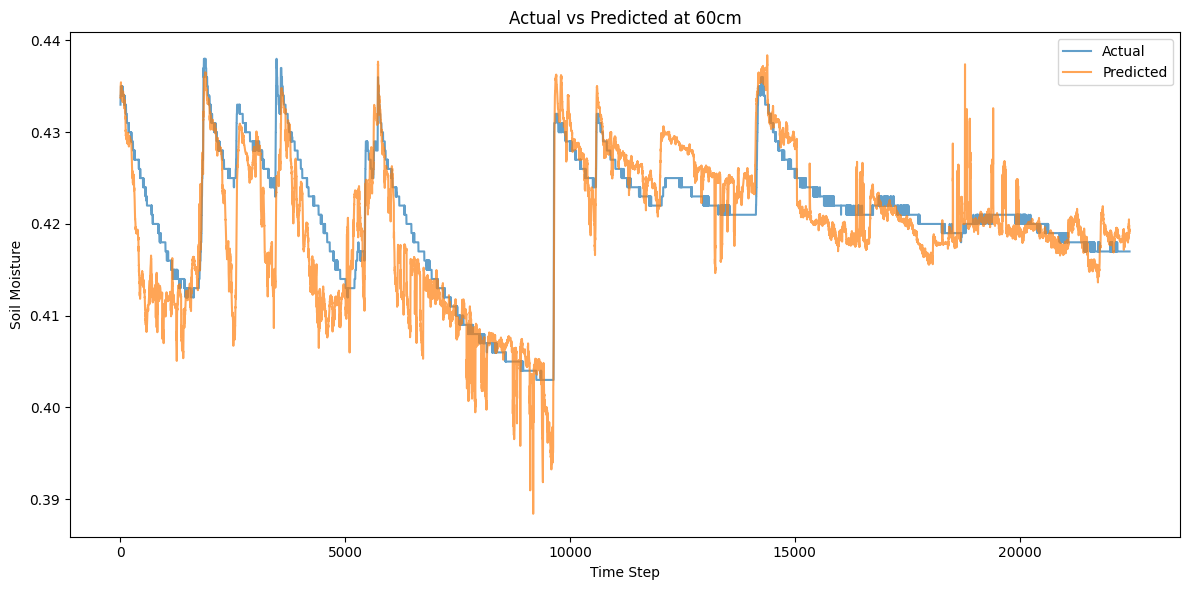

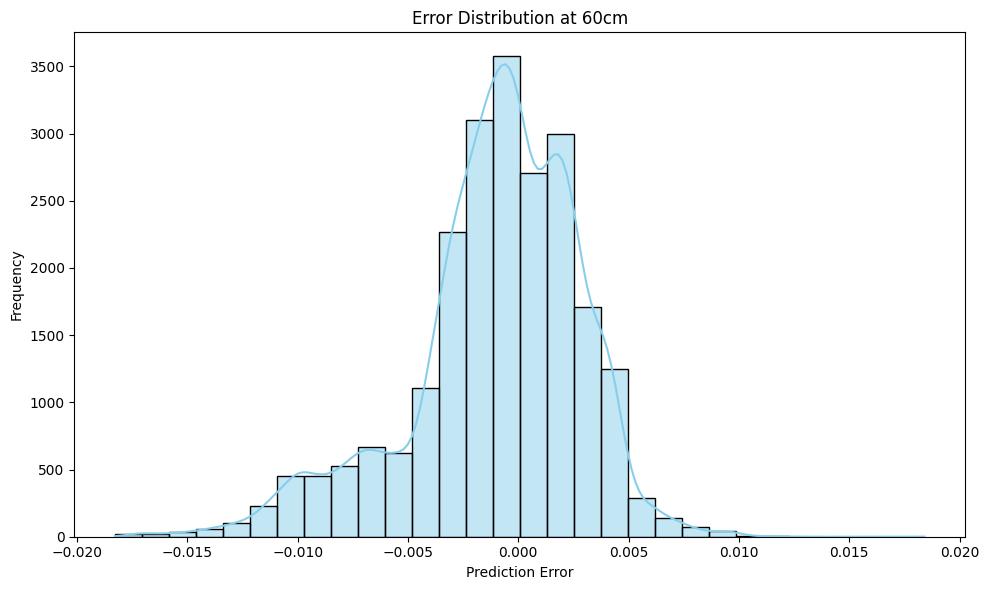

In [ ]:
# === Visualization: Actual vs Predicted for 60cm ===
def plot_actual_vs_predicted_single(y_true, y_pred, label='60cm'):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual', alpha=0.7)
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.title(f'Actual vs Predicted at {label}')
    plt.xlabel('Time Step')
    plt.ylabel('Soil Moisture')
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Visualization: Error Distribution for 60cm ===
def plot_error_distribution_single(y_true, y_pred, label='60cm'):
    errors = y_pred - y_true
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Error Distribution at {label}')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# === Call Visualization Functions for 60cm ===
plot_actual_vs_predicted_single(y_test_seq, y_pred_final, label='60cm')
plot_error_distribution_single(y_test_seq, y_pred_final, label='60cm')


#Predict moisture 30cm

In [ ]:
# ==== Define features to exclude ====
features_to_exclude = ['moisture_20cm', 'moisture_60cm', 'moisture_40cm', 'moisture_30cm', 'timestamp_device']

# ==== Create input and target arrays ====
X_raw = base_df.drop(columns=features_to_exclude).values
y_raw = base_df['moisture_30cm'].values

# ==== Scale features ====
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_raw)

# ==== Create sequences ====
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 12
X_seq, y_seq = create_sequences(X_scaled, y_raw, sequence_length)

# ==== Train-test split ====
split_index = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]
# ==== Custom Callback ====
class R2RMSECallback(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0).flatten()
        r2 = r2_score(self.y_val, y_pred)
        rmse = mean_squared_error(self.y_val, y_pred, squared=False)
        print(f"Epoch {epoch+1}: R² = {r2:.4f}, RMSE = {rmse:.4f}")

# ==== Build LSTM model ====
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
lstm_model.add(Dense(1))

# ==== Compile model ====
lstm_model.compile(optimizer=Adam(), loss='mean_squared_error')

from tensorflow.keras.callbacks import EarlyStopping

# ==== Early Stopping Callback ====
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ==== Train model ====
lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[R2RMSECallback(X_test_seq, y_test_seq), early_stopping]
)

# ==== Final Evaluation ====
y_pred_final = lstm_model.predict(X_test_seq).flatten()
final_mae = mean_absolute_error(y_test_seq, y_pred_final)
final_rmse = mean_squared_error(y_test_seq, y_pred_final, squared=False)
final_r2 = r2_score(y_test_seq, y_pred_final)

# ==== Print final results ====
print("\n=== Final LSTM Results (Time Sequences) ===")
print(f"MAE: {final_mae:.4f}, RMSE: {final_rmse:.4f}, R²: {final_r2:.4f}")

In [ ]:
sequence_length = 144
X_seq, y_seq = create_sequences(X_scaled, y_raw, sequence_length)

# ==== Train-test split ====
split_index = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]
# ==== Custom Callback ====
class R2RMSECallback(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0).flatten()
        r2 = r2_score(self.y_val, y_pred)
        rmse = mean_squared_error(self.y_val, y_pred, squared=False)
        print(f"Epoch {epoch+1}: R² = {r2:.4f}, RMSE = {rmse:.4f}")

# ==== Build LSTM model ====
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
lstm_model.add(Dense(1))

# ==== Compile model ====
lstm_model.compile(optimizer=Adam(), loss='mean_squared_error')

from tensorflow.keras.callbacks import EarlyStopping

# ==== Early Stopping Callback ====
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ==== Train model ====
lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[R2RMSECallback(X_test_seq, y_test_seq), early_stopping]
)

# ==== Final Evaluation ====
y_pred_final = lstm_model.predict(X_test_seq).flatten()
final_mae = mean_absolute_error(y_test_seq, y_pred_final)
final_rmse = mean_squared_error(y_test_seq, y_pred_final, squared=False)
final_r2 = r2_score(y_test_seq, y_pred_final)

# ==== Print final results ====
print("\n=== Final LSTM Results (Time Sequences) ===")
print(f"MAE: {final_mae:.4f}, RMSE: {final_rmse:.4f}, R²: {final_r2:.4f}")

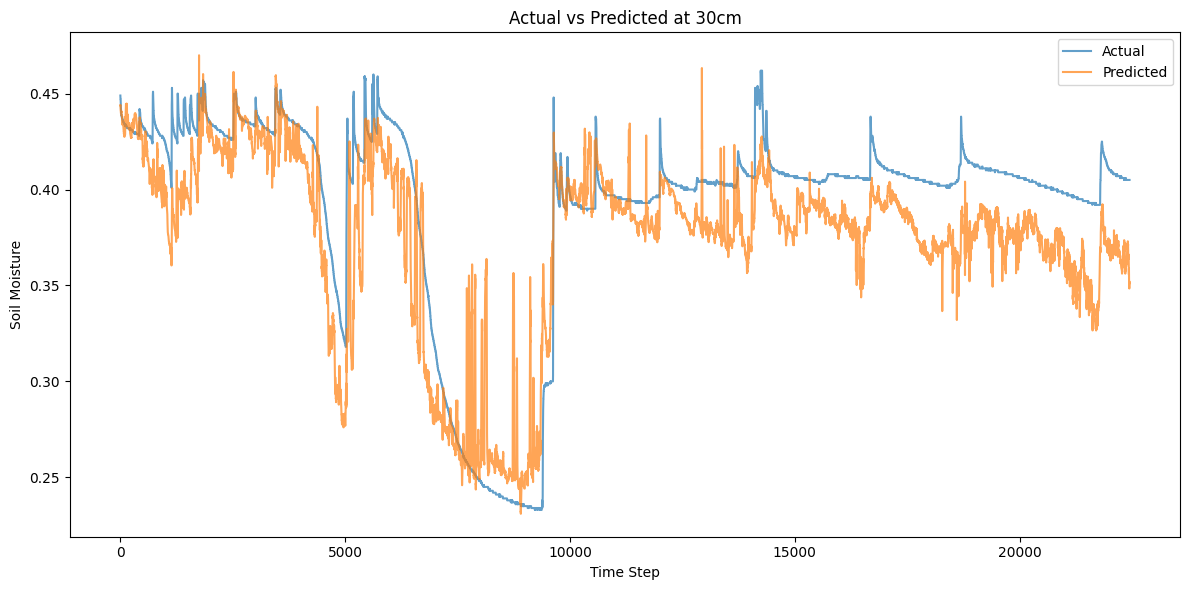

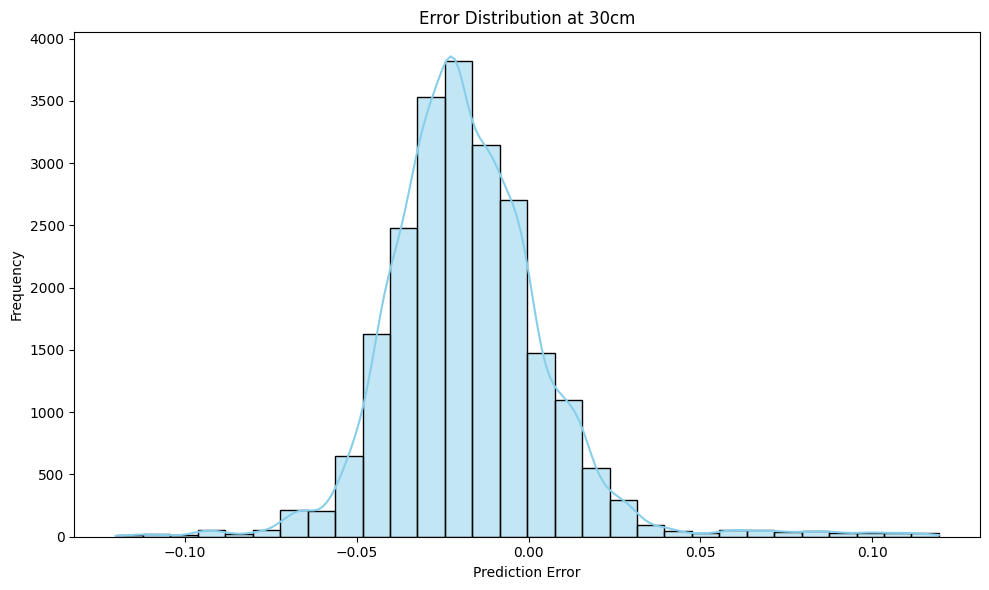

In [ ]:
# === Visualization: Actual vs Predicted for 30cm ===
def plot_actual_vs_predicted_single(y_true, y_pred, label='30cm'):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual', alpha=0.7)
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.title(f'Actual vs Predicted at {label}')
    plt.xlabel('Time Step')
    plt.ylabel('Soil Moisture')
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Visualization: Error Distribution for 30cm ===
def plot_error_distribution_single(y_true, y_pred, label='30cm'):
    errors = y_pred - y_true
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Error Distribution at {label}')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# === Call Visualization Functions for 30cm ===
plot_actual_vs_predicted_single(y_test_seq, y_pred_final, label='30cm')
plot_error_distribution_single(y_test_seq, y_pred_final, label='30cm')

#Predicting moisture at 20cm depth

In [ ]:
# ==== Define features to exclude ====
features_to_exclude = ['moisture_20cm', 'moisture_60cm', 'moisture_40cm', 'moisture_30cm', 'timestamp_device']

# ==== Create input and target arrays ====
X_raw = base_df.drop(columns=features_to_exclude).values
y_raw = base_df['moisture_20cm'].values

# ==== Scale features ====
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_raw)

# ==== Create sequences ====
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 12
X_seq, y_seq = create_sequences(X_scaled, y_raw, sequence_length)

# ==== Train-test split ====
split_index = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]
# ==== Custom Callback ====
class R2RMSECallback(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0).flatten()
        r2 = r2_score(self.y_val, y_pred)
        rmse = mean_squared_error(self.y_val, y_pred, squared=False)
        print(f"Epoch {epoch+1}: R² = {r2:.4f}, RMSE = {rmse:.4f}")

# ==== Build LSTM model ====
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
lstm_model.add(Dense(1))

# ==== Compile model ====
lstm_model.compile(optimizer=Adam(), loss='mean_squared_error')

from tensorflow.keras.callbacks import EarlyStopping

# ==== Early Stopping Callback ====
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ==== Train model ====
lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[R2RMSECallback(X_test_seq, y_test_seq), early_stopping]
)

# ==== Final Evaluation ====
y_pred_final = lstm_model.predict(X_test_seq).flatten()
final_mae = mean_absolute_error(y_test_seq, y_pred_final)
final_rmse = mean_squared_error(y_test_seq, y_pred_final, squared=False)
final_r2 = r2_score(y_test_seq, y_pred_final)

# ==== Print final results ====
print("\n=== Final LSTM Results (Time Sequences) ===")
print(f"MAE: {final_mae:.4f}, RMSE: {final_rmse:.4f}, R²: {final_r2:.4f}")

In [ ]:
sequence_length = 144
X_seq, y_seq = create_sequences(X_scaled, y_raw, sequence_length)

# ==== Train-test split ====
split_index = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]
# ==== Custom Callback ====
class R2RMSECallback(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0).flatten()
        r2 = r2_score(self.y_val, y_pred)
        rmse = mean_squared_error(self.y_val, y_pred, squared=False)
        print(f"Epoch {epoch+1}: R² = {r2:.4f}, RMSE = {rmse:.4f}")

# ==== Build LSTM model ====
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
lstm_model.add(Dense(1))

# ==== Compile model ====
lstm_model.compile(optimizer=Adam(), loss='mean_squared_error')

from tensorflow.keras.callbacks import EarlyStopping

# ==== Early Stopping Callback ====
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ==== Train model ====
lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[R2RMSECallback(X_test_seq, y_test_seq), early_stopping]
)

# ==== Final Evaluation ====
y_pred_final = lstm_model.predict(X_test_seq).flatten()
final_mae = mean_absolute_error(y_test_seq, y_pred_final)
final_rmse = mean_squared_error(y_test_seq, y_pred_final, squared=False)
final_r2 = r2_score(y_test_seq, y_pred_final)

# ==== Print final results ====
print("\n=== Final LSTM Results (Time Sequences) ===")
print(f"MAE: {final_mae:.4f}, RMSE: {final_rmse:.4f}, R²: {final_r2:.4f}")

In [ ]:
# === Visualization: Actual vs Predicted for 20cm ===
def plot_actual_vs_predicted_single(y_true, y_pred, label='20cm'):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual', alpha=0.7)
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.title(f'Actual vs Predicted at {label}')
    plt.xlabel('Time Step')
    plt.ylabel('Soil Moisture')
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Visualization: Error Distribution for 40cm ===
def plot_error_distribution_single(y_true, y_pred, label='20cm'):
    errors = y_pred - y_true
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Error Distribution at {label}')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# === Call Visualization Functions for 60cm ===
plot_actual_vs_predicted_single(y_test_seq, y_pred_final, label='20cm')
plot_error_distribution_single(y_test_seq, y_pred_final, label='20cm')

#Predicting moisture at 40cm depth

In [ ]:
# ==== Define features to exclude ====
base_df = base_df_resampled.sort_values('timestamp_device')  # Ensure chronological order

features_to_exclude = ['moisture_20cm', 'moisture_60cm', 'moisture_40cm', 'moisture_30cm', 'timestamp_device']

# ==== Create input and target arrays ====
X_raw = base_df.drop(columns=features_to_exclude).values
y_raw = base_df['moisture_40cm'].values

# ==== Scale features ====
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_raw)

# ==== Create sequences ====
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 12
X_seq, y_seq = create_sequences(X_scaled, y_raw, sequence_length)

# ==== Train-test split ====
split_index = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]
# ==== Custom Callback ====
class R2RMSECallback(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0).flatten()
        r2 = r2_score(self.y_val, y_pred)
        rmse = mean_squared_error(self.y_val, y_pred, squared=False)
        print(f"Epoch {epoch+1}: R² = {r2:.4f}, RMSE = {rmse:.4f}")

# ==== Build LSTM model ====
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
lstm_model.add(Dense(1))

# ==== Compile model ====
lstm_model.compile(optimizer=Adam(), loss='mean_squared_error')

from tensorflow.keras.callbacks import EarlyStopping

# ==== Early Stopping Callback ====
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ==== Train model ====
lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[R2RMSECallback(X_test_seq, y_test_seq), early_stopping]
)

# ==== Final Evaluation ====
y_pred_final = lstm_model.predict(X_test_seq).flatten()
final_mae = mean_absolute_error(y_test_seq, y_pred_final)
final_rmse = mean_squared_error(y_test_seq, y_pred_final, squared=False)
final_r2 = r2_score(y_test_seq, y_pred_final)

# ==== Print final results ====
print("\n=== Final LSTM Results (Time Sequences) ===")
print(f"MAE: {final_mae:.4f}, RMSE: {final_rmse:.4f}, R²: {final_r2:.4f}")

In [ ]:
sequence_length = 144
X_seq, y_seq = create_sequences(X_scaled, y_raw, sequence_length)

# ==== Train-test split ====
split_index = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]
# ==== Custom Callback ====
class R2RMSECallback(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0).flatten()
        r2 = r2_score(self.y_val, y_pred)
        rmse = mean_squared_error(self.y_val, y_pred, squared=False)
        print(f"Epoch {epoch+1}: R² = {r2:.4f}, RMSE = {rmse:.4f}")

# ==== Build LSTM model ====
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
lstm_model.add(Dense(1))

# ==== Compile model ====
lstm_model.compile(optimizer=Adam(), loss='mean_squared_error')

from tensorflow.keras.callbacks import EarlyStopping

# ==== Early Stopping Callback ====
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ==== Train model ====
lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[R2RMSECallback(X_test_seq, y_test_seq), early_stopping]
)

# ==== Final Evaluation ====
y_pred_final = lstm_model.predict(X_test_seq).flatten()
final_mae = mean_absolute_error(y_test_seq, y_pred_final)
final_rmse = mean_squared_error(y_test_seq, y_pred_final, squared=False)
final_r2 = r2_score(y_test_seq, y_pred_final)

# ==== Print final results ====
print("\n=== Final LSTM Results (Time Sequences) ===")
print(f"MAE: {final_mae:.4f}, RMSE: {final_rmse:.4f}, R²: {final_r2:.4f}")

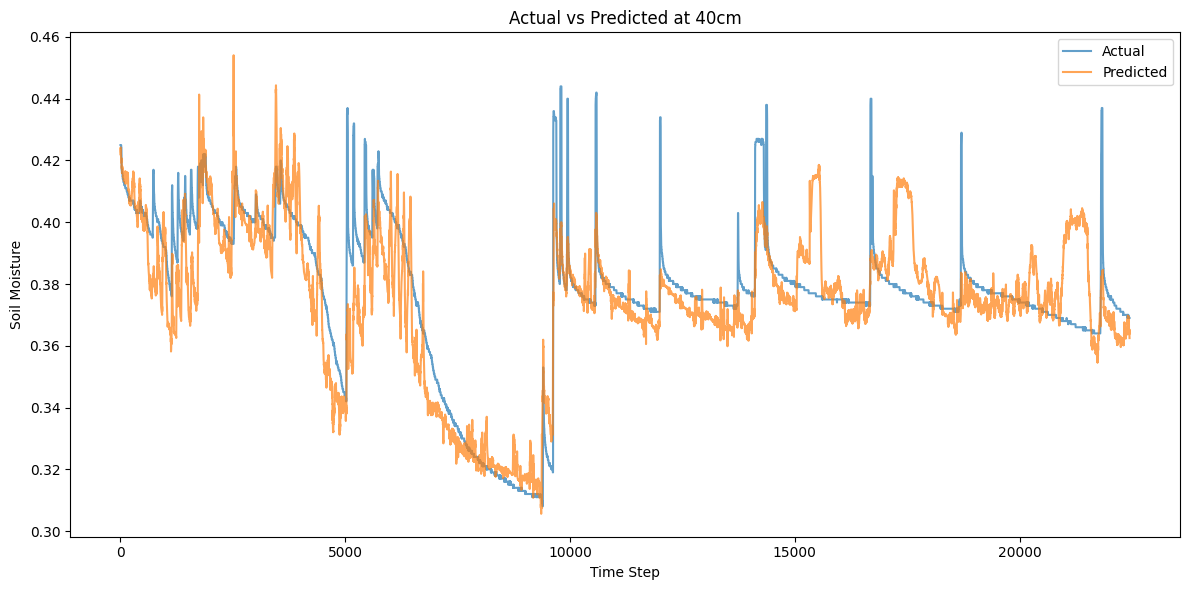

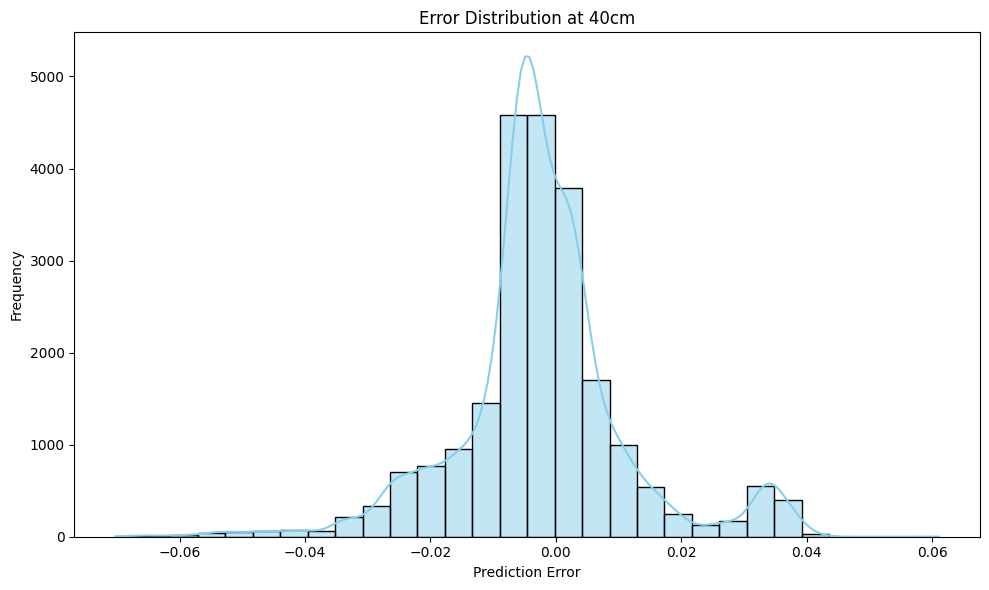

In [ ]:
# === Visualization: Actual vs Predicted for 40cm ===
def plot_actual_vs_predicted_single(y_true, y_pred, label='60cm'):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual', alpha=0.7)
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.title(f'Actual vs Predicted at {label}')
    plt.xlabel('Time Step')
    plt.ylabel('Soil Moisture')
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Visualization: Error Distribution for 40cm ===
def plot_error_distribution_single(y_true, y_pred, label='40cm'):
    errors = y_pred - y_true
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Error Distribution at {label}')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# === Call Visualization Functions for 60cm ===
plot_actual_vs_predicted_single(y_test_seq, y_pred_final, label='40cm')
plot_error_distribution_single(y_test_seq, y_pred_final, label='40cm')


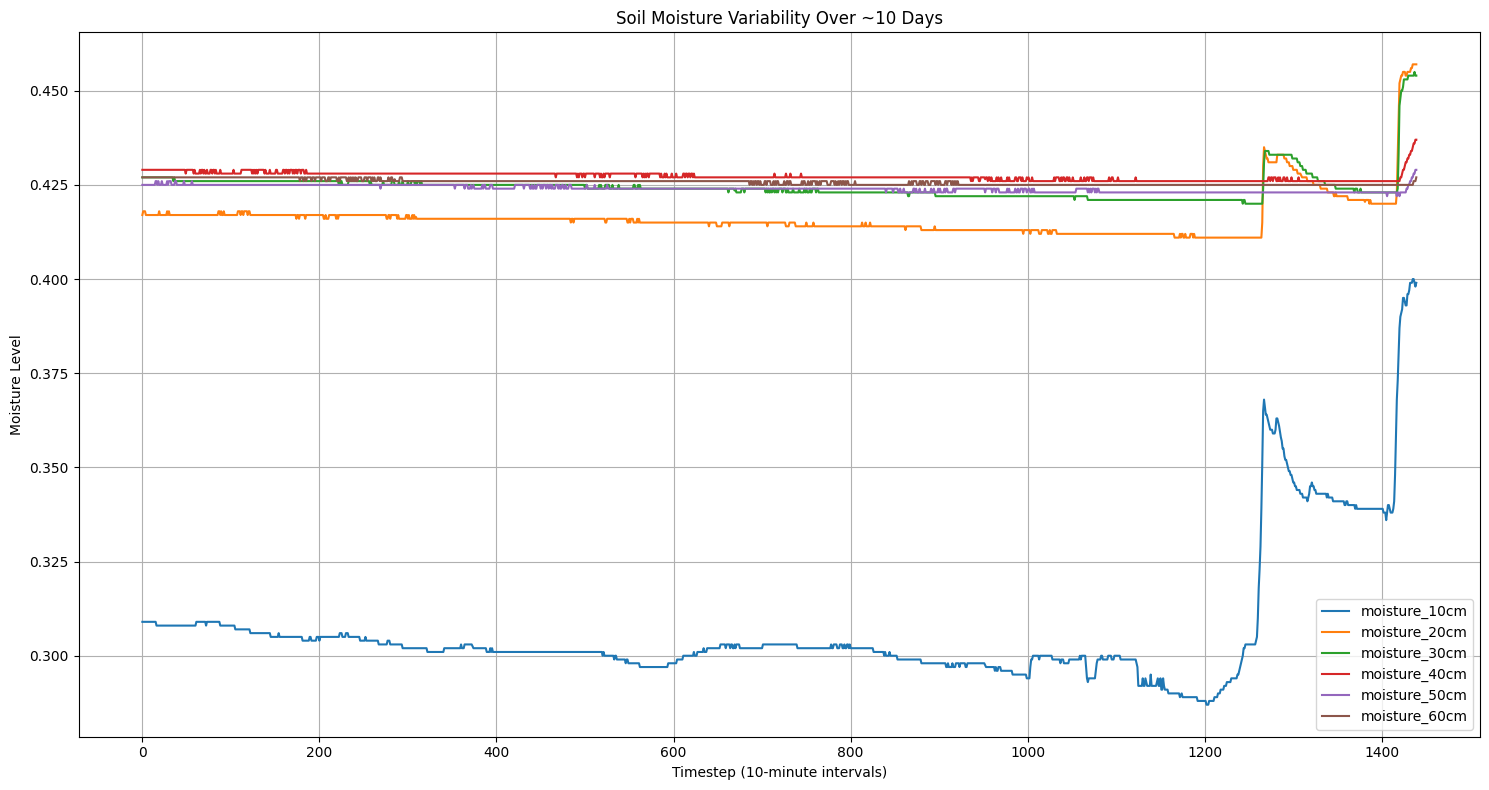

In [ ]:
df = base_df_resampled
# Select moisture columns
moisture_columns = ['moisture_10cm', 'moisture_20cm', 'moisture_30cm',
                    'moisture_40cm', 'moisture_50cm', 'moisture_60cm']

# Plot a sample (~10 days if 10-minute intervals = 1440 records)
sample_df = df[moisture_columns].iloc[:1440]

plt.figure(figsize=(15, 8))
for col in moisture_columns:
    plt.plot(sample_df[col], label=col)

plt.title("Soil Moisture Variability Over ~10 Days")
plt.xlabel("Timestep (10-minute intervals)")
plt.ylabel("Moisture Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
